# Airfoil Optimization using NeuralFoil

In this tutorial, we'll use AeroSandbox for airfoil shape optimization, with aerodynamic, structural, and manufacturability constraints.

## A Brief Introduction to Airfoil Parameterization with `asb.KulfanAirfoil`

To do airfoil optimization (or at least, to do it well), we need to introduce a new class: `asb.KulfanAirfoil`.

`asb.KulfanAirfoil` is a subclass of `asb.Airfoil` (i.e., for the most part, it can do all the same things), except that the underlying parameterization is not a coordinate array, but rather a set of Kulfan (sometimes also called "CST") parameters. These Kulfan parameters correspond to the strengths of various mode shapes, which then are combined linearly to obtain a given airfoil shape.

* For more information on this Kulfan (CST) parameterization, see Brenda Kulfan's papers:
    * [Kulfan, Brenda, "Universal Parametric Geometry Representation Method", 2008](https://www.brendakulfan.com/_files/ugd/169bff_6738e0f8d9074610942c53dfaea8e30c.pdf)
    * [Kulfan, Brenda, "Modification of CST Airfoil Representation Methodology"](https://www.brendakulfan.com/_files/ugd/169bff_16a868ad06af4fea946d299c6028fb13.pdf)
* And, for more details on why the Kulfan parameterization is an efficient and industry-standard airfoil parameterization choice, see:
    * [Masters, D. A. et al., "A Geometric Comparison of Aerofoil Shape Parameterisation Methods", 2016](https://www.researchgate.net/publication/298033011_A_Geometric_Comparison_of_Aerofoil_Shape_Parameterisation_Methods)

Going to/from an Airfoil and a KulfanAirfoil is easy:

In [16]:
import aerosandbox as asb
import aerosandbox.numpy as np
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

First, let's start with a standard (coordinate-based) `asb.Airfoil`:

In [17]:
coordinate_airfoil = asb.Airfoil("dae11")
coordinate_airfoil

Airfoil dae11 (81 points)

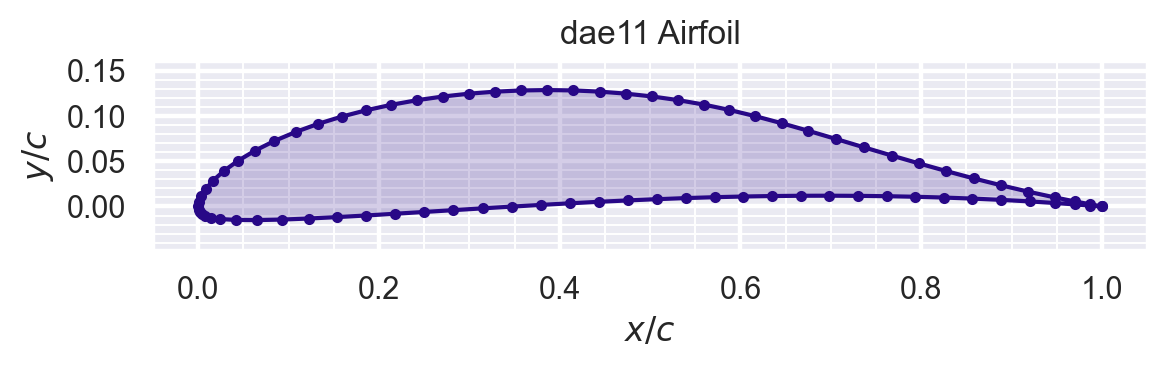

In [18]:
fig, ax = plt.subplots(figsize=(6, 2))
coordinate_airfoil.draw()

Now, let's convert it to a `asb.KulfanAirfoil`:

In [19]:
kulfan_airfoil = coordinate_airfoil.to_kulfan_airfoil()
kulfan_airfoil

Airfoil dae11 (Kulfan / CST parameterization)

As you can see below, the represented airfoil is essentially exactly identical. Also, note that you can still use all the same methods as before, like `draw()`:

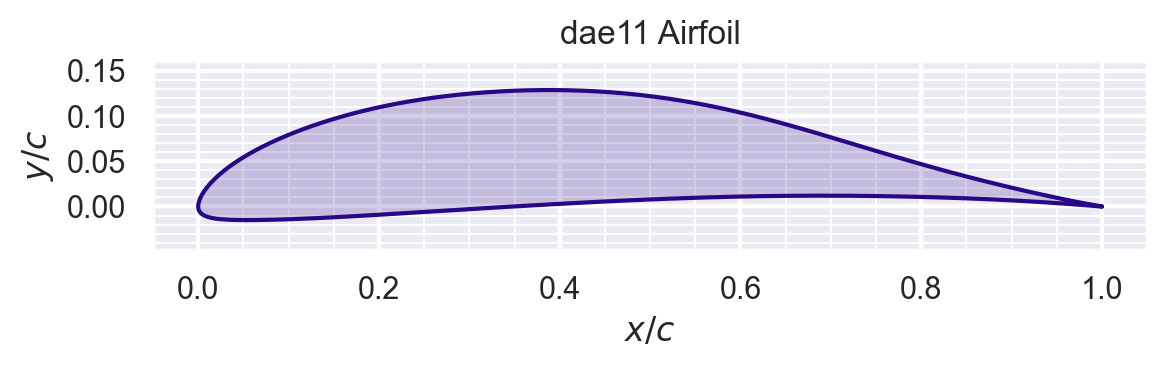

In [20]:
fig, ax = plt.subplots(figsize=(6, 2))
kulfan_airfoil.draw()

If you want to look "under the hood", you can see the Kulfan (CST) parameterization here:

In [21]:
from pprint import pprint  # "pretty print"

pprint(kulfan_airfoil.kulfan_parameters)

{'TE_thickness': 0.00011059192135129403,
 'leading_edge_weight': 0.5035068867316314,
 'lower_weights': array([-0.16310508, -0.14398528,  0.08896135, -0.0706084 ,  0.09741634,
        0.01466031,  0.07888292,  0.08075122]),
 'upper_weights': array([0.17036014, 0.15272658, 0.51688551, 0.09212467, 0.66904449,
       0.14345864, 0.28990386, 0.16207357])}


Much more compact than a full Nx2 coordinate array!

Converting back from a `KulfanAirfoil` to an `Airfoil` is also easy:

In [22]:
kulfan_airfoil.to_airfoil()

Airfoil dae11 (399 points)

You can also just instantiate a `asb.KulfanAirfoil` directly, if you want. For example, from any UIUC-database or NACA airfoil name:

In [23]:
asb.KulfanAirfoil("dae11")

Airfoil dae11 (Kulfan / CST parameterization)

Or, more directly:

In [24]:
asb.KulfanAirfoil(
    name="My Airfoil",
    lower_weights=-0.3 * np.ones(8),
    upper_weights=0.3 * np.ones(8),
    leading_edge_weight=0.,
    TE_thickness=0.005,
)

Airfoil My Airfoil (Kulfan / CST parameterization)

Ok, enough about `KulfanAirfoil` for now. Let's get back to optimization!

## Airfoil Optimization for a Human-Powered Aircraft

Here, we recreate an airfoil optimization test case from Drela's paper "Pros and Cons of Airfoil Optimization".

The case we're focusing on aims to design an airfoil for a Human Powered Aircraft (HPA) application, similar to that of MIT Daedalus:

![daedalus-and-airfoil](./assets/daedalus_and_airfoil.svg)

The original problem, as formulated in the first section of Drela's paper, is to:

* Minimize $C_D$ at $\mathrm{Re}_c = 500\mathrm{K}$ and $\mathrm{M}_\infty = 0.03$
* By changing airfoil shape and angle of attack $\alpha$
* Subject to:
    * $C_L = 1.25$
    * $C_M = -0.133$
    * Trailing-edge angle $\theta_{TE} = 6.25\degree$
    * Leading-edge angle $\theta_{LE} = 180\degree$ (Basically, prevent the formation of a chisel-type leading edge)
    * At $x/c = 0.33$, $t/c = 0.128$
    * At $x/c = 0.90$, $t/c = 0.014$

Note that in Drela's paper, all of these constraints are formulated as equality constraints (as opposed to inequality constraints) due to the Lagrange-multiplier-based optimization formulation used in his work. Here, we will modify some of these constraints (e.g., $\theta_{TE}$) to be inequality constraints, to both demonstrate the syntax here and to better capture the engineering design goals of the original design problem.

The thesis of Drela's (excellent) paper is basically to show empirically that single-point optimization like the problem above is fraught, as the optimizer will over-optimize to the single specified lift coefficient.

Later in Drela's work, an improved formulation that leverages multipoint optimization (i.e., optimizing across multiple operating points) is presented. This yields much more robust airfoil designs that are less sensitive to precise operating conditions.

Here, we will solve a very similar multipoint optimization problem:

* Minimize $C_{D, \mathrm{mean}}$ at $\mathrm{Re}_c = 500\mathrm{K}$ and $\mathrm{M}_\infty = 0.03$
    * Where $C_{D, \mathrm{mean}}$ is the average of $C_D$ at the following lift coefficients:
        * $C_L = 0.8, 1.0, 1.2, 1.4, 1.5, 1.6$
* By changing airfoil shape and angle of attack $\alpha$
* Subject to:
    * $C_M \geq -0.133$ (at all $C_L$ operating points)
    * Trailing-edge angle $\theta_{TE} \geq 6.25\degree$
    * Leading-edge angle $\theta_{LE} = 180\degree$ (Basically, prevent the formation of a chisel-type leading edge)
    * At $x/c = 0.33$, $t/c \geq 0.128$
    * At $x/c = 0.90$, $t/c \geq 0.014$

We will also add some "regularization" constraints that tend to make airfoil optimization better-behaved by ruling out non-physical and unrealistic airfoils. It turns out that in this simple airfoil optimization case, these are not necessary and the optimizer will converge regardless. However, they are demonstrated here as they are "best practices" for airfoil optimization on more complicated problems:

The first such constraint is that the airfoil thickness must be positive everywhere. This is implemented as `optimized_airfoil.local_thickness() > 0`. This prevents the creation of self-intersecting airfoils, which can be analyzed in both XFoil and NeuralFoil, but are obviously not physically-valid shapes.

The second such constraint aims to guide the optimizer away from airfoils that are excessively "wiggly", as these have boundary layer behavior that is quite difficult to predict. Our measure of the "wiggliness" of an airfoil, $w$, is based on the same metric that has successfully been used for decades in univariate spline regularization (See: [Wabha, Grace, "Spline Models for Observational Data"](https://epubs.siam.org/doi/book/10.1137/1.9781611970128)):

$$w(\mathrm{airfoil}) = \int_0^1 \left( \frac{d^2}{dx^2} y_\mathrm{lower}(x) \right)^2 + \left( \frac{d^2}{dx^2} y_\mathrm{upper}(x) \right)^2 dx$$

We can approximate this wiggliness $w$ in a discrete sense as:

$$w(\mathrm{airfoil}) \approx \sum_{i=2}^{N-1} \left(c_{\mathrm{lower},i+1} - 2 \cdot c_{\mathrm{lower},i} + c_{\mathrm{lower},i-1} \right)^2 + \left(c_{\mathrm{upper},i+1} - 2 \cdot c_{\mathrm{upper},i} + c_{\mathrm{upper},i-1} \right)^2$$

Where $c_{\mathrm{lower},i}$ and $c_{\mathrm{upper},i}$ are the $i$th Kulfan (CST) coefficients of the lower and upper surfaces, respectively. Note that a $dx^2$-like constant has been dropped, so really this discrete approximation is just a proportionality.

We constrain this wiggliness $w$ to be no more than 4 times that of the initial guess airfoil, which is a reasonable heuristic that tends to work well in practice.


Below is the implementation in AeroSandbox. We start from an initial guess of a NACA0012 airfoil.

In [25]:
CL_multipoint_targets = np.array([0.8, 1.0, 1.2, 1.4, 1.5, 1.6])

Re = 500e3
mach = 0.03

initial_guess_airfoil = asb.KulfanAirfoil("naca0012")
initial_guess_airfoil.name = "Initial Guess (NACA0012)"

opti = asb.Opti()

optimized_airfoil = asb.KulfanAirfoil(
    name="Optimized",
    lower_weights=opti.variable(
        init_guess=initial_guess_airfoil.lower_weights,
        lower_bound=-0.5,
        upper_bound=0.25,
    ),
    upper_weights=opti.variable(
        init_guess=initial_guess_airfoil.upper_weights,
        lower_bound=-0.25,
        upper_bound=0.5,
    ),
    leading_edge_weight=opti.variable(
        init_guess=initial_guess_airfoil.leading_edge_weight,
        lower_bound=-1,
        upper_bound=1,
    ),
    TE_thickness=0,
)

alpha = opti.variable(
    init_guess=np.degrees(CL_multipoint_targets / (2 * np.pi)),
    lower_bound=-5,
    upper_bound=18
)

aero = optimized_airfoil.get_aero_from_neuralfoil(
    alpha=alpha,
    Re=Re,
    mach=mach,
)

opti.subject_to([
    aero["CL"] == CL_multipoint_targets,
    np.diff(alpha) > 0,
    aero["CM"] >= -0.133,
    optimized_airfoil.local_thickness(x_over_c=0.33) >= 0.128,
    optimized_airfoil.local_thickness(x_over_c=0.90) >= 0.014,
    optimized_airfoil.TE_angle() >= 6.25,
    optimized_airfoil.lower_weights[0] < -0.1,
    optimized_airfoil.upper_weights[0] > 0.1,
])

opti.subject_to(
    optimized_airfoil.local_thickness() > 0
)

get_wiggliness = lambda af: sum([
    np.sum(np.diff(np.diff(array)) ** 2)
    for array in [af.lower_weights, af.upper_weights]
])

opti.subject_to(
    get_wiggliness(optimized_airfoil) < 4 * get_wiggliness(initial_guess_airfoil)
)

opti.minimize(np.mean(aero["CD"]))

sol = opti.solve(
    behavior_on_failure="return_last"
)

optimized_airfoil = sol(optimized_airfoil)
aero = sol(aero)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      108
Number of nonzeros in inequality constraint Jacobian.:     1935
Number of nonzeros in Lagrangian Hessian.............:      261
Total number of variables............................:       23
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        6
Total number of inequality constraints...............:      164
        inequality constraints with only lower bounds:      139
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       25

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.5744148e-02 4.79e-01 1.04e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

Below, we compare three airfoils:
* The initial guess airfoil (a NACA0012)
* The resulting airfoil from our optimization study
* The DAE-11 airfoil, which is an expert-designed airfoil designed with the exact same objective and constraints as the optimization problem we've posed here.

We compare both their shape and their aerodynamic performance (by means of their $C_D$-$C_L$ polars).

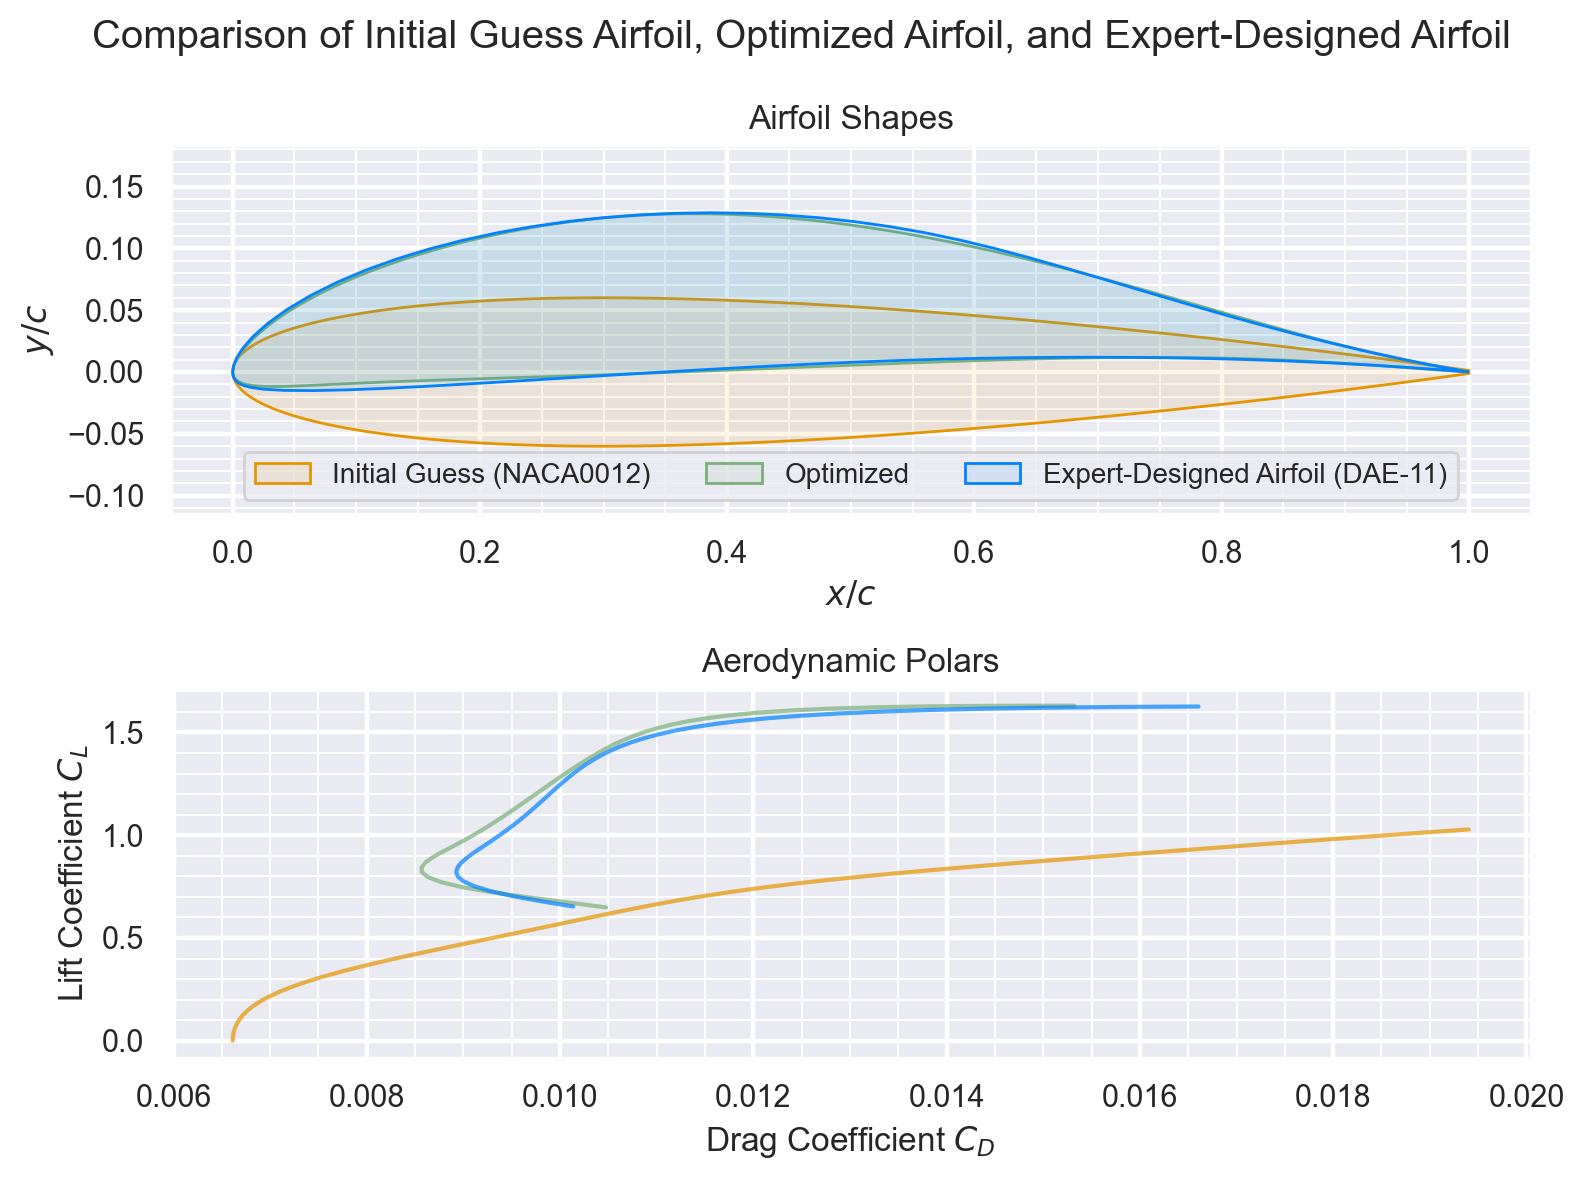

In [26]:
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

fig, ax = plt.subplots(2, 1, figsize=(8, 6))

dae11 = asb.Airfoil("dae11")
dae11.name = "Expert-Designed Airfoil (DAE-11)"

for i, af in enumerate([
    initial_guess_airfoil,
    optimized_airfoil,
    dae11
]):
    # color = p.adjust_lightness(p.palettes["categorical"][i])
    color = p.adjust_lightness(["orange", "darkseagreen", "dodgerblue"][i], 0.9)

    ax[0].fill(
        af.x(), af.y(),
        facecolor=(*color, 0.1),
        edgecolor=(*color, 1),
        linewidth=1,
        label=af.name
    )
    nf_aero = af.get_aero_from_neuralfoil(
        alpha=np.linspace(0, 10),
        Re=Re,
        mach=mach,
    )
    ax[1].plot(
        nf_aero["CD"], nf_aero["CL"],  #"--",
        color=color, alpha=0.7
    )
ax[0].legend(fontsize=10, loc="lower center", ncol=3)
ax[0].set_title("Airfoil Shapes")
ax[0].set_xlabel("$x/c$")
ax[0].set_ylabel("$y/c$")
ax[0].axis('equal')

ax[1].set_title("Aerodynamic Polars")
ax[1].set_xlabel("Drag Coefficient $C_D$")
ax[1].set_ylabel("Lift Coefficient $C_L$")
p.show_plot("Comparison of Initial Guess Airfoil, Optimized Airfoil, and Expert-Designed Airfoil", legend=False)

As we can see, our optimization routine produces an exceptionally-similar airfoil to the expert-designed airfoil.

It's not quite as good as the expert-designed airfoil in terms of drag minimization (it has apparently become stuck in a local minimum), but it's very close. This is especially useful as it started from a "blank slate" initial guess of a NACA0012. This is more-than-adequate for conceptual design, and provides a good starting point for expert-guided refinement.

## Airfoil Optimization for Low-Reynolds, High-Transonic Applications

In [27]:
Re = 500e3
mach = 0.8

initial_guess_airfoil = asb.KulfanAirfoil("naca0080")
initial_guess_airfoil.name = "Initial Guess (NACA0080)"

opti = asb.Opti()

optimized_airfoil = asb.KulfanAirfoil(
    name="Optimized",
    lower_weights=opti.variable(
        init_guess=initial_guess_airfoil.lower_weights,
        lower_bound=-0.5,
        upper_bound=0.25,
    ),
    upper_weights=opti.variable(
        init_guess=initial_guess_airfoil.upper_weights,
        lower_bound=-0.25,
        upper_bound=0.5,
    ),
    leading_edge_weight=opti.variable(
        init_guess=initial_guess_airfoil.leading_edge_weight,
        lower_bound=-0.5,
        upper_bound=0.5,
    ),
    TE_thickness=0,
)

alpha = opti.variable(init_guess=0, lower_bound=-20, upper_bound=20)

alphas = alpha + np.linspace(-3, 3, 11)

aero = optimized_airfoil.get_aero_from_neuralfoil(
    alpha=alpha,
    Re=Re,
    mach=mach,
    model_size="xlarge"
)

opti.minimize(np.mean(-aero["CL"] / aero["CD"]))

opti.subject_to(
    optimized_airfoil.local_thickness() > 0
)

airfoil_history = []
aero_history = []


def callback(i):
    airfoil_history.append(
        asb.KulfanAirfoil(
            name="in-progress",
            lower_weights=opti.debug.value(optimized_airfoil.lower_weights),
            upper_weights=opti.debug.value(optimized_airfoil.upper_weights),
            leading_edge_weight=opti.debug.value(optimized_airfoil.leading_edge_weight),
            TE_thickness=opti.debug.value(optimized_airfoil.TE_thickness),
        )
    )
    aero_history.append({
        k: opti.debug.value(v) for k, v in aero.items()
    })


sol = opti.solve(
    max_iter=100,
    callback=callback
)

optimized_airfoil = sol(optimized_airfoil)
aero = sol(aero)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1753
Number of nonzeros in Lagrangian Hessian.............:      171

Total number of variables............................:       18
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      137
        inequality constraints with only lower bounds:      119
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       18

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0967888e-14 6.57e-01 3.20e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

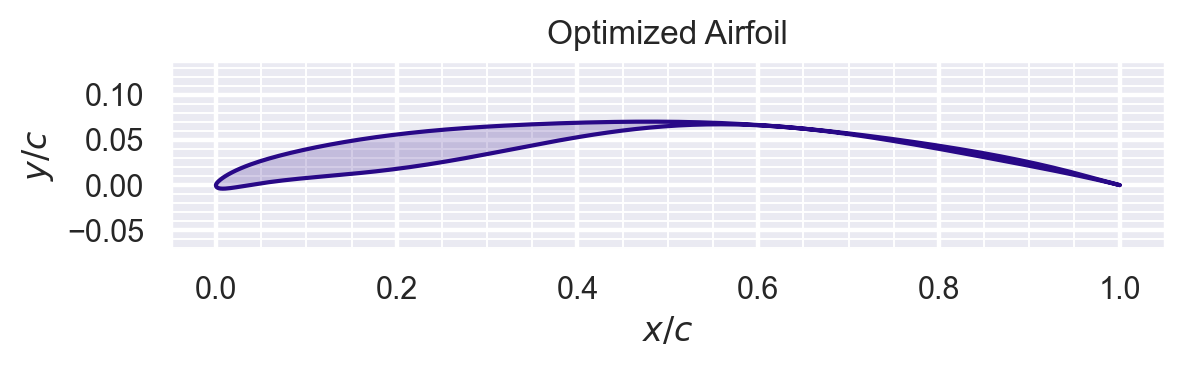

In [28]:
fig, ax = plt.subplots(figsize=(6, 2))
optimized_airfoil.draw()

This has a corresponding $L/D$ of:

In [29]:
print(f"L / D = {sol(aero['CL'] / aero['CD']):.1f}")

L / D = 223.6


C:\Users\PeterSharpe\AppData\Local\Temp\ipykernel_15588\2769605352.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\PeterSharpe\Desktop\AeroSandbox\aerosandbox\tools\pretty_plots\plots\plot_color_by_value.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmap)


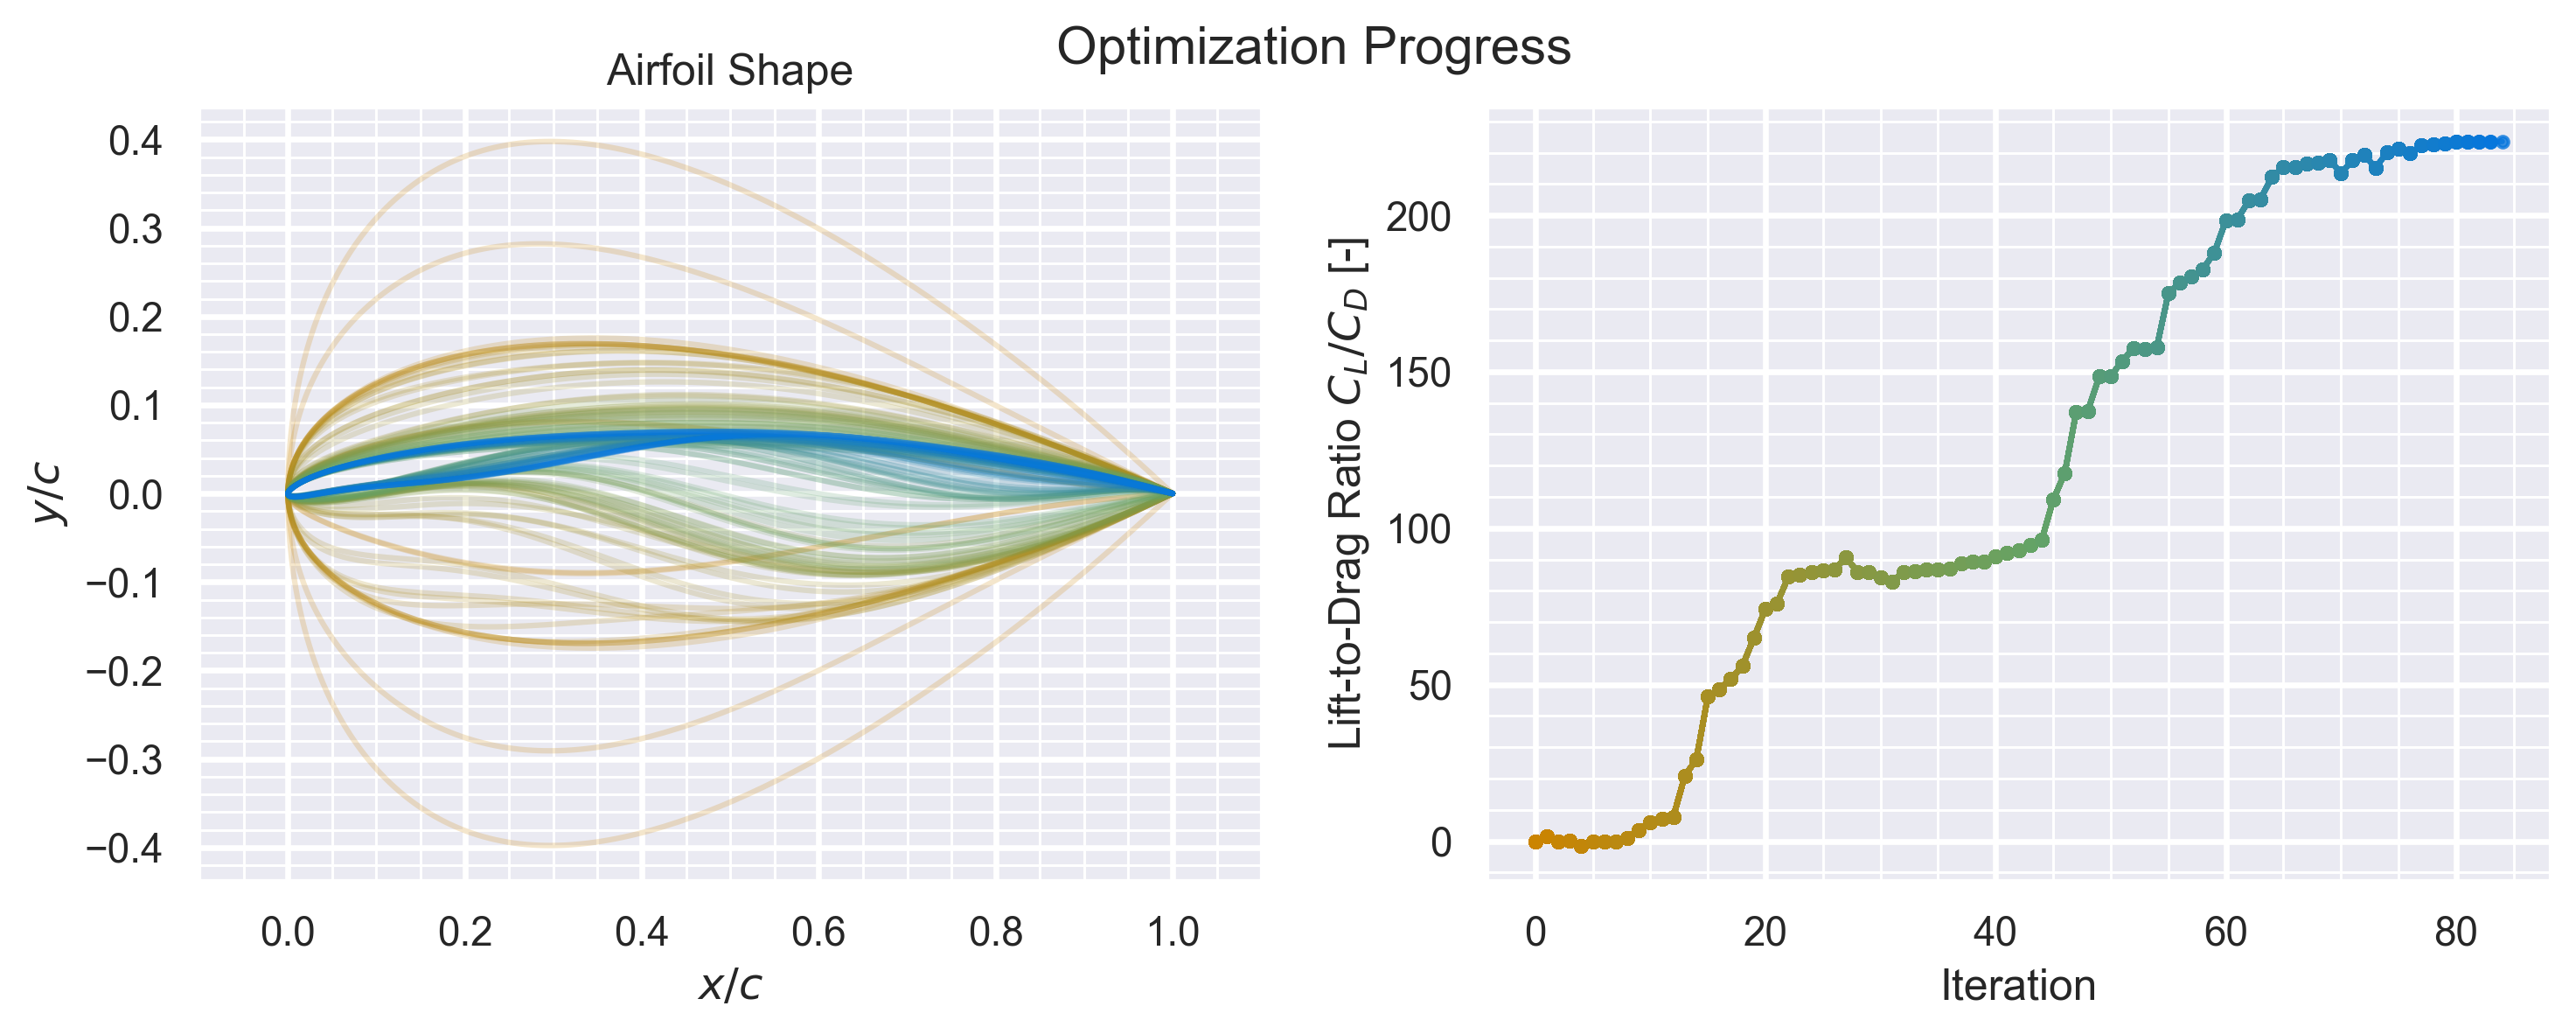

In [30]:
# NBVAL_SKIP

import matplotlib
from matplotlib.animation import ArtistAnimation

fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=300)
p.show_plot(show=False)
ax[0].set_title("Airfoil Shape")
ax[0].set_xlabel("$x/c$")
ax[0].set_ylabel("$y/c$")

ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Lift-to-Drag Ratio $C_L/C_D$ [-]")
plt.tight_layout()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    "custom_cmap",
    colors=[
        p.adjust_lightness(c, 0.8) for c in
        ["orange", "darkseagreen", "dodgerblue"]
    ]
)

colors = cmap(np.linspace(0, 1, len(airfoil_history)))

ims = []
for i in range(len(airfoil_history)):
    plt.sca(ax[0])
    plt.plot(
        airfoil_history[i].x(),
        airfoil_history[i].y(),
        "-",
        color=colors[i],
        alpha=0.2,
    )
    plt.axis('equal')

    plt.sca(ax[1])
    if i > 0:
        p.plot_color_by_value(
            np.arange(i),
            np.array([
                np.mean(aero_history[j]["CL"] / aero_history[j]["CD"])
                for j in range(i)
            ]),
            ".-",
            c=np.arange(i),
            cmap=cmap,
            clim=(0, len(airfoil_history)),
            alpha=0.8
        )


    plt.suptitle(f"Optimization Progress")

    ims.append([
        *ax[0].get_children(),
        *ax[1].get_children(),
        *fig.get_children(),
    ])

ims.extend([ims[-1]] * 30)

ani = ArtistAnimation(fig, ims, interval=100)

# writer = matplotlib.animation.PillowWriter(fps=10)
# ani.save("assets/airfoil_optimization.gif", writer=writer)

writer = matplotlib.animation.FFMpegWriter(fps=10)
try:
    ani.save("assets/airfoil_optimization.mp4", writer=writer)
except FileNotFoundError as e:
    raise FileNotFoundError(
        "You likely do not have `ffmpeg` on PATH and need to install it / set up PATH accordingly."
    ) from e

del ani

<video width="900" src="./assets/airfoil_optimization.mp4" controls>
</video>